In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import time
import copy
import cv2

In [2]:
from flatland.envs.observations import TreeObsForRailEnv, LocalObsForRailEnv, GlobalObsForRailEnv
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import complex_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator
from flatland.utils.rendertools import RenderTool

## Preprocessing the agent's observation to remove background embellishments

In [3]:
from PIL import Image, ImageDraw, ImageFont
from numpy import array
from pkg_resources import resource_string as resource_bytes

from flatland.utils.graphics_layer import GraphicsLayer

from flatland.core.grid.rail_env_grid import RailEnvTransitions 

from flatland.utils.graphics_pil import PILGL, PILSVG

In [4]:
np.random.seed(1)

# Use the complex_rail_generator to generate feasible network configurations with corresponding tasks
# Training on simple small tasks is the best way to get familiar with the environment
N_agents = 1
width = 20
height = 20
#max_dist=99999
max_dist=50
env_seed = 1

TreeObservation = TreeObsForRailEnv(max_depth=2, predictor=ShortestPathPredictorForRailEnv())
LocalGridObs = LocalObsForRailEnv(view_height=10, view_width=2, center=2)
GlobalObs = GlobalObsForRailEnv()
rail_generator = complex_rail_generator(nr_start_goal=10, nr_extra=2, min_dist=8, max_dist=max_dist, seed=env_seed)
env = RailEnv(width=width, height=height,
              rail_generator= rail_generator,
              schedule_generator=complex_schedule_generator(), 
              number_of_agents=N_agents, 
              obs_builder_object=GlobalObs)

In [5]:
def set_rail_at_new(self, row, col, binary_trans, target=None, is_selected=False, rail_grid=None, num_agents=None,
                show_debug=True):
    
    if binary_trans in self.pil_rail:
        pil_track = self.pil_rail[binary_trans]
        if target is not None:
            target_img = self.station_colors[target % len(self.station_colors)]
            target_img = Image.alpha_composite(pil_track, target_img)
            self.draw_image_row_col(target_img, (row, col), layer=PILGL.TARGET_LAYER)
            if show_debug:
                self.text_rowcol((row + 0.8, col + 0.0), strText=str(target), layer=PILGL.TARGET_LAYER)

        city_size = 1
        if num_agents is not None:
            city_size = max(1, np.log(1 + num_agents) / 2.5)

        self.draw_image_row_col(pil_track, (row, col), layer=PILGL.RAIL_LAYER)
    else:
        print("Illegal rail:", row, col, format(binary_trans, "#018b")[2:], binary_trans)

    if target is not None:
        if is_selected:
            svgBG = self.pil_from_png_file('flatland.png', "Selected_Target.png")
            self.clear_layer(PILGL.SELECTED_TARGET_LAYER, 0)
            self.draw_image_row_col(svgBG, (row, col), layer=PILGL.SELECTED_TARGET_LAYER)

In [6]:
import types

In [7]:
env.reset()
env_renderer = RenderTool(env, gl="PILSVG")

In [8]:
funcType = types.MethodType
env_renderer = RenderTool(env)
env_renderer.gl.set_rail_at = funcType(set_rail_at_new, env_renderer.gl)

In [9]:
env_renderer.render_env(show=False)
env_image = env_renderer.get_image()
env_image.shape

/home/prarit/anaconda3/envs/flatland-rl/lib/python3.6/site-packages/flatland/utils/rendertools.py:396: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


(464, 464, 4)

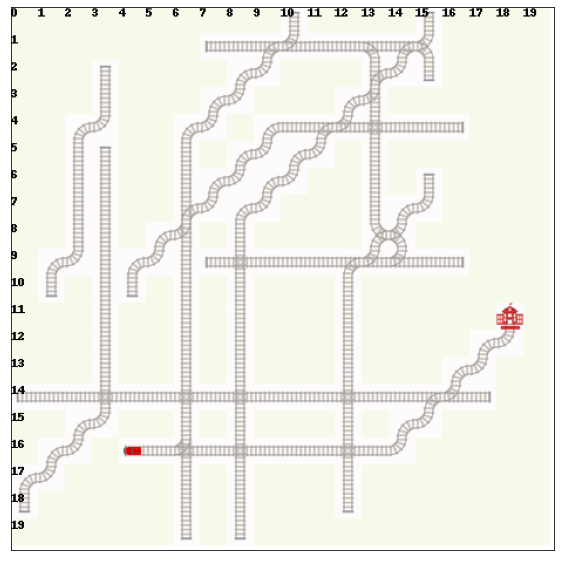

In [10]:
plt.figure(figsize = (10,10))
plt.imshow(env_image[:,:,:3])
plt.xticks([])
plt.yticks([])
plt.show()

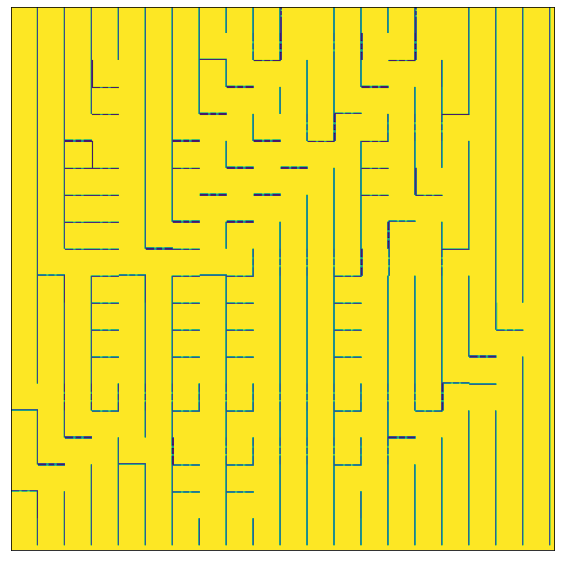

In [11]:
# the fourth channel of the image seems to be unnecessary noise
plt.figure(figsize = (10,10))
plt.imshow(env_image[:,:,3])
plt.xticks([])
plt.yticks([])
plt.show()

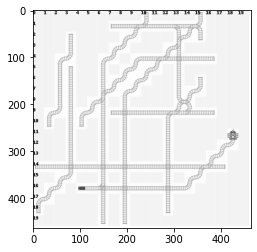

In [12]:
# reduce to a grayscale image by taking the mean of pixel values along the channel dim.
im = (env_image).mean(axis = 2) 
#im = cv2.resize(im, (87, 87), interpolation = cv2.INTER_AREA)
plt.imshow(im, cmap = "gray")
plt.show()

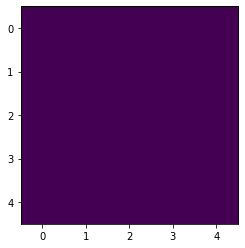

In [13]:
im = (env_image).mean(axis = 2) 
plt.imshow(im[5:10,5:10])
plt.show()

In [14]:
# average pixel value of empty portions in the image
im[5:10,5:10]

array([[246.75, 246.75, 246.75, 246.75, 246.75],
       [246.75, 246.75, 246.75, 246.75, 246.75],
       [246.75, 246.75, 246.75, 246.75, 246.75],
       [246.75, 246.75, 246.75, 246.75, 246.75],
       [246.75, 246.75, 246.75, 246.75, 246.75]])

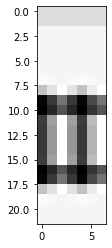

In [15]:
# A small section of a rail
im = (env_image).mean(axis = 2) 
plt.imshow(im[21:43, 170:177], cmap = 'gray')
plt.show()

In [16]:
# A small section of a rail
im[21:43, 170:177]

array([[246.75, 246.75, 246.75, 246.75, 246.75, 246.75, 246.75],
       [246.75, 246.75, 246.75, 246.75, 246.75, 246.75, 246.75],
       [252.5 , 252.5 , 252.5 , 252.5 , 252.5 , 252.5 , 252.5 ],
       [252.5 , 252.5 , 252.5 , 252.5 , 252.5 , 252.5 , 252.5 ],
       [252.5 , 252.5 , 252.5 , 252.5 , 252.5 , 252.5 , 252.5 ],
       [252.5 , 252.5 , 252.5 , 252.5 , 252.5 , 252.5 , 252.5 ],
       [252.5 , 252.5 , 252.5 , 252.5 , 252.5 , 252.5 , 252.5 ],
       [254.  , 253.25, 252.5 , 253.25, 254.  , 253.25, 252.5 ],
       [240.  , 247.75, 255.  , 247.75, 240.  , 250.  , 255.  ],
       [194.25, 206.75, 221.25, 206.75, 194.25, 210.75, 221.25],
       [193.  , 202.5 , 213.75, 202.5 , 193.  , 205.75, 213.75],
       [208.  , 231.75, 255.  , 231.75, 208.  , 238.75, 255.  ],
       [207.  , 229.75, 255.  , 229.75, 207.  , 236.5 , 255.  ],
       [207.  , 229.75, 255.  , 229.75, 207.  , 236.5 , 255.  ],
       [207.  , 229.75, 255.  , 229.75, 207.  , 236.5 , 255.  ],
       [208.  , 231.75, 2

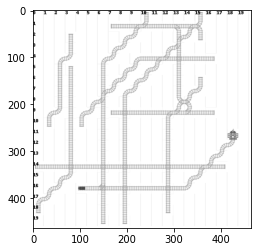

In [17]:
# following seems to be a clearer grayscale image
im = (env_image).mean(axis = 2)
mask1 = im == 246.75 # 246.75 is the mean value of pixels that correspond to empty cells
mask2 = im == 252.5 # 252.5 is the mean value of blank pixels around the cells containing rails
im[np.where(mask1)] -=(246.75-255.0)
im[np.where(mask2)] -=(252.5-255.0)
#im = im/255.0-1.0
#im = cv2.resize(im, (87, 87), interpolation = cv2.INTER_AREA)
plt.imshow(im, cmap = 'gray')

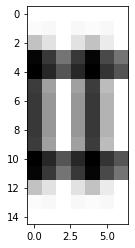

In [18]:
# A small section of a rail
plt.imshow(im[27:42, 170:177], cmap = 'gray')

In [19]:
im[27:42, 170:177]

array([[255.  , 255.  , 255.  , 255.  , 255.  , 255.  , 255.  ],
       [254.  , 253.25, 255.  , 253.25, 254.  , 253.25, 255.  ],
       [240.  , 247.75, 255.  , 247.75, 240.  , 250.  , 255.  ],
       [194.25, 206.75, 221.25, 206.75, 194.25, 210.75, 221.25],
       [193.  , 202.5 , 213.75, 202.5 , 193.  , 205.75, 213.75],
       [208.  , 231.75, 255.  , 231.75, 208.  , 238.75, 255.  ],
       [207.  , 229.75, 255.  , 229.75, 207.  , 236.5 , 255.  ],
       [207.  , 229.75, 255.  , 229.75, 207.  , 236.5 , 255.  ],
       [207.  , 229.75, 255.  , 229.75, 207.  , 236.5 , 255.  ],
       [208.  , 231.75, 255.  , 231.75, 208.  , 238.75, 255.  ],
       [193.  , 202.5 , 213.75, 202.5 , 193.  , 205.75, 213.75],
       [194.25, 206.75, 221.25, 206.75, 194.25, 210.75, 221.25],
       [240.  , 247.75, 255.  , 247.75, 240.  , 250.  , 255.  ],
       [254.  , 253.25, 255.  , 253.25, 254.  , 253.25, 255.  ],
       [255.  , 255.  , 255.  , 255.  , 255.  , 255.  , 255.  ]])

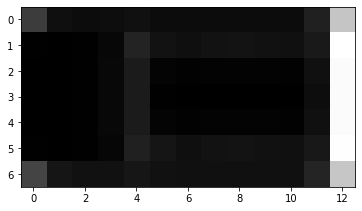

In [20]:
# the cell containing the train 
plt.imshow(im[376:383, 99:112], cmap = 'gray')

In [21]:
im[376:383, 99:112]

array([[147.25, 124.75, 123.  , 123.75, 125.25, 123.25, 123.  , 123.  ,
        123.  , 123.  , 123.  , 133.5 , 214.75],
       [117.5 , 117.  , 117.75, 120.5 , 134.5 , 126.25, 124.75, 126.25,
        126.75, 125.5 , 125.  , 129.75, 243.5 ],
       [117.  , 117.  , 117.75, 121.  , 130.75, 119.  , 118.  , 118.5 ,
        118.5 , 118.5 , 118.  , 125.  , 241.25],
       [117.  , 117.  , 117.75, 121.  , 130.75, 117.75, 117.25, 117.25,
        117.25, 117.25, 117.25, 123.75, 241.25],
       [117.  , 117.  , 117.75, 121.  , 130.75, 119.  , 118.  , 118.5 ,
        118.5 , 118.5 , 118.  , 125.  , 241.25],
       [117.5 , 117.  , 117.75, 120.  , 133.75, 127.75, 124.75, 126.25,
        126.75, 125.5 , 125.  , 129.25, 242.75],
       [151.  , 127.5 , 125.75, 125.75, 128.  , 125.5 , 125.25, 125.25,
        125.25, 125.25, 125.25, 135.5 , 215.25]])

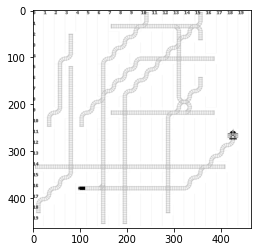

In [22]:
# enhance the train
train = np.ma.masked_inside(im, 117, 147.25).mask
im[np.where(train)]=0
plt.imshow(im, cmap = 'gray')

In [23]:
import copy

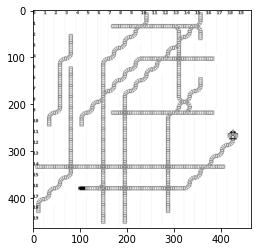

In [24]:
# enhance the rails
im2 = copy.deepcopy(im)
rail = np.ma.masked_inside(im, 193, 221.25).mask
im2[np.where(rail)]=255.0/2
plt.imshow(im2, cmap = 'gray')

In [25]:
# function to apply the above transformations to the image and rescale it
def GrayScale(img):
    """
    function to scale the pixel values to lie between 0 and 1 
    We will also convert the images to grayscale by taking mean along the channel dimention
    """
    img = img.mean(axis = 2)
    mask1 = img == 246.75 # 246.75 is the mean value of pixels that correspond to empty cells
    mask2 = img == 252.5 # 252.5 is the mean value of blank pixels around the cells containing rails
    img[np.where(mask1)] -=(246.75-255.0)
    img[np.where(mask2)] -=(252.5-255.0)
    
    # enhance train
    train = np.ma.masked_inside(img, 100, 192.99).mask # this is range of pixel values for the train
    img[np.where(train)]=0
    
    # enhance the rails
    rail = np.ma.masked_inside(img, 193, 221.25).mask
    img[np.where(rail)]=255.0/2
    
    # set the rest of the pixel to blank
    rest1 = np.ma.masked_inside(img, 221.25, 255.0).mask
    img[np.where(rest1)]=255.0
    
    # this will also get rid of the row and col. numbers in the image
    rest2 = np.ma.masked_inside(img, 1, 100).mask
    img[np.where(rest2)]=255.0
    
    img = img/255.0-1
    
    #img = img.transpose(2,0,1)
    img = cv2.resize(img, (87, 87), interpolation = cv2.INTER_AREA)
    #img = cv2.resize(img, (87, 87), interpolation = cv2.INTER_LANCZOS4)
    img = img.reshape(-1,87,87)
    #print('gray scaled image shape', img.shape)
    return img

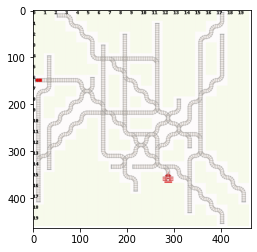

In [26]:
env.reset()
env_renderer.reset()
env_renderer.render_env(show=False)
env_img = env_renderer.get_image() 
plt.imshow(env_img)
plt.show()

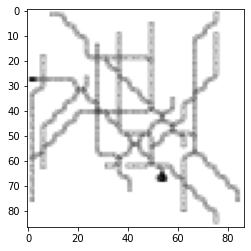

In [27]:
img = GrayScale(env_img)
plt.imshow(img[0], cmap = "gray")
plt.show()

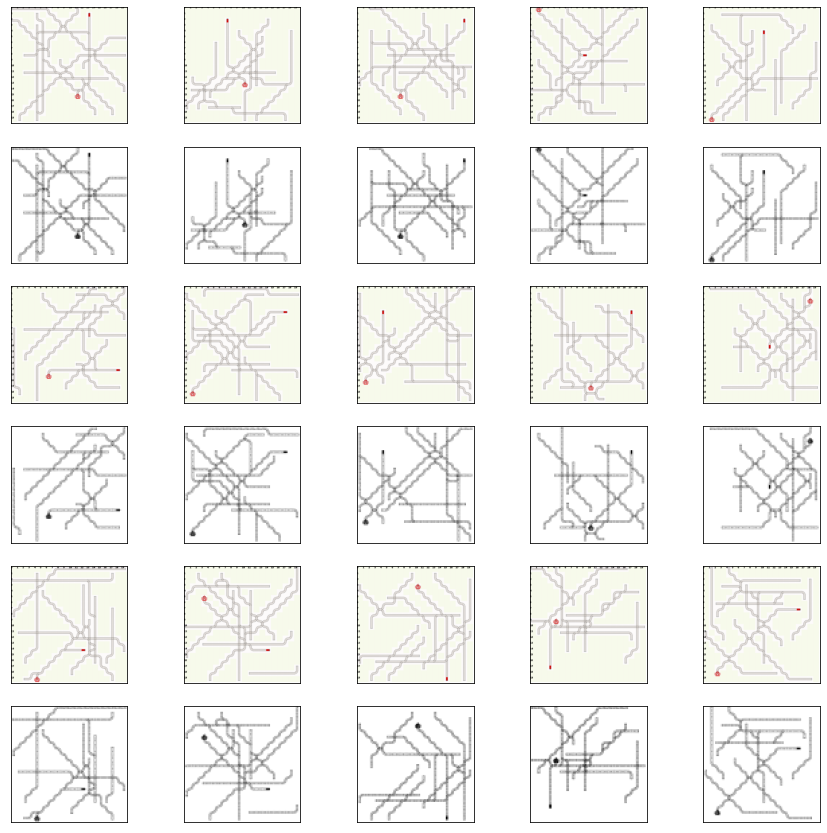

In [28]:
# sample of transformations applied via the GrayScale function
nrows = 6
ncols = 5
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (15,15))
for row in range(0, nrows, 2):
    for col in range(ncols):
        env.reset()
        env_renderer.reset()
        env_renderer.render_env(show=False)
        env_img = env_renderer.get_image() 
        ax[row, col].imshow(env_img)
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        img = GrayScale(env_img)
        ax[row+1, col].imshow(img[0], cmap = "gray")
        ax[row+1, col].set_xticks([])
        ax[row+1, col].set_yticks([])

## Training an Agent

In [29]:
from collections import deque

In [30]:
env.reset()
env_renderer = RenderTool(env)
funcType = types.MethodType
env_renderer = RenderTool(env)
env_renderer.gl.set_rail_at = funcType(set_rail_at_new, env_renderer.gl)

In [31]:
def donesDict2List(done, num_agents):
    donesList = []
    for agent_idx in range(num_agents):
        assert agent_idx in done, "Error: done dictionary does not contain agent-{}".format(agent_idx)
        donesList.append(int(done[agent_idx]))
    
    return donesList

In [32]:
def rewardsDict2List(all_rewards, num_agents, num_max_steps):
    rewardsList = []
    for agent_idx in range(num_agents):
        assert agent_idx in all_rewards, "Error: rewards dictionary does not contain agent-{}".format(agent_idx)
        rewardsList.append(all_rewards[agent_idx]/num_max_steps)
    
    return rewardsList       

In [33]:
def single_agent_DQN(agent, num_agents=1, num_episodes = 10, roll_out = 5, num_max_steps = 20):
    ep_scores = [] # list containing scores from each episode
    scores_window = deque(maxlen = 100) # scores of last 100 episodes
    experience_window = deque(maxlen = roll_out) # agent's experience over the past roll_out steps
    for episode in range(1, num_episodes+1):
        # Reset environment and get initial observations for all agents
        env.reset()
        env_renderer.reset()
        score = 0
        env_renderer.render_env(show=False)
        #env_renderer.render_env(show=True, show_observations=True, show_predictions=False)
        state = GrayScale(env_renderer.get_image())
        step_ctr = 0
        for steps in range(roll_out-1):
            actions = agent.act(state)
            action_dict = {0:actions[0]} # for single agent scenario, agent has index 0
            _, all_rewards, done, _ = env.step(action_dict)
            env_renderer.render_env(show=False)
            #env_renderer.render_env(show=True, show_observations=True, show_predictions=False)
            next_state = GrayScale(env_renderer.get_image()) 
            reward = all_rewards[0] # reward of the 0th agent
            rewardsList = rewardsDict2List(all_rewards, num_agents, num_max_steps)
            donesList = donesDict2List(done, num_agents)
            single_step_memory = (state, actions, rewardsList, next_state, donesList)
            state = next_state
            experience_window.append(single_step_memory)
            score+=reward
            step_ctr+=1
            if done['__all__']:
                break
            
        while True:
            if step_ctr>num_max_steps:
                break
            actions = agent.act(state)
            action_dict = {0:actions[0]} # for single agent scenario, agent has index 0
            _, all_rewards, done, _ = env.step(action_dict)
            env_renderer.render_env(show=False)
            #env_renderer.render_env(show=True, show_observations=True, show_predictions=False)
            next_state = GrayScale(env_renderer.get_image())
            reward = all_rewards[0] # reward of the 0th agent
            rewardsList = rewardsDict2List(all_rewards, num_agents, num_max_steps)
            donesList = donesDict2List(done, num_agents)
            single_step_memory = (state, actions, rewardsList, next_state, donesList)
            state = next_state
            experience_window.append(single_step_memory)
            score+=reward
            step_ctr+=1    
            
            window = copy.deepcopy(experience_window) # otherwise a shallow copy of the experience window is saved to memories
                                                      # which will then cause all the memories to be essentially identical
            agent.step(window)
            if done['__all__']:
                break
            
            
        scores_window.append(score)
        ep_scores.append(score)
        
        memories_len = agent.memory.__len__()
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tMemories: {} '.format(episode, np.mean(scores_window), memories_len), end="")
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tMemories: {}'.format(episode, np.mean(scores_window), memories_len))
            # print('memory size: {}'.format(len(agent.memory)))
            
    return ep_scores

In [34]:
from DuellingDoubleDQNAgent import DuellingDoubleDQNAgent

cuda


In [35]:
num_agents = N_agents
im_height = 87
im_width = 87
obs_in_channels= 1
kernel_size = 3
roll_out = 5
epsilon = 0.1
lr = 0.005
replay_batch_size = 96
update_interval = 4
buffer_size = 2**16 # kernel seems to die with larger than 2**16 buffer size (when using 87 x 87 images and roll_out = 5) 
agent = DuellingDoubleDQNAgent(num_agents= num_agents, 
                               im_height = im_height, 
                               im_width = im_width, 
                               obs_in_channels=obs_in_channels,
                               roll_out = roll_out,
                               kernel_size = kernel_size, 
                               lr = lr,
                               epsilon = epsilon, 
                               replay_batch_size = replay_batch_size,
                               update_interval = update_interval,
                               buffer_size = buffer_size)

Created 1 local networks
Created 1 target networks
Created 1 optimizers


In [ ]:
num_episodes = 5000
num_max_steps = 150
all_scores = single_agent_DQN(agent, num_agents, num_episodes, roll_out, num_max_steps)

Episode 100	Average Score: -105.40	Memories: 10222 
Episode 200	Average Score: -107.27	Memories: 20631 
Episode 300	Average Score: -117.45	Memories: 32042 
Episode 400	Average Score: -113.45	Memories: 43061 
Episode 488	Average Score: -118.43	Memories: 53318 

In [ ]:
avg = np.mean(all_scores)
print('average score of a random agent over {} episodes is {}'.format(num_episodes, avg))

In [ ]:
plt.figure()
plt.plot(range(1,len(all_scores)+1), all_scores )
plt.xlabel("Episode no.")
plt.ylabel("Episode score")
plt.show()